In [1]:
import pandas as pd

In [4]:
df=pd.read_table('sms_spam_collection/SMSSpamCollection.tsv',sep='\t',header=None,names=['Label','Text'])
df=df.iloc[:,::-1]
df

,Text,Label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will ü b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [5]:
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [9]:
# DataFrame的sample随机采样函数；n表示抽取行的数量
# 进行下采样，得到数量一致的数据
def create_balanced_dataset(df):
    num=df[df['Label']=='spam'].shape[0]
    sample=df[df['Label']=='ham'].sample(n=num,random_state=123)
    return pd.concat([df[df['Label']=='spam'],sample])
balanced_df=create_balanced_dataset(df)
balanced_df['Label'].value_counts()
balanced_df

,Text,Label
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
5,FreeMsg Hey there darling it's been 3 week's n...,spam
8,WINNER!! As a valued network customer you have...,spam
9,Had your mobile 11 months or more? U R entitle...,spam
11,"SIX chances to win CASH! From 100 to 20,000 po...",spam
...,...,...
4707,Wow so healthy. Old airport rd lor. Cant thk o...,ham
3293,Dear good morning how you feeling dear,ham
1278,Dont put your phone on silent mode ok,ham
4079,Gam gone after outstanding innings.,ham


In [32]:
balanced_df['Label']=balanced_df['Label'].map(lambda x:0 if x=='ham' else 1)
# balanced_df.iloc[00]

C:\Users\31986\AppData\Local\Temp\ipykernel_2056\3975428144.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balanced_df.iloc[0][0]


"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [22]:
# frac表示抽取行的比例
# Listing 6.3 Splitting the dataset
def random_split(df, train_frac, validation_frac):
    df=df.sample(frac=1,random_state=123).reset_index(drop=True)
    lens=df.shape[0]
    begin=int(train_frac*lens)
    mid=int(lens*(train_frac+validation_frac))
    train_df=df.iloc[:begin,:]
    validation_df=df.iloc[begin:mid,:]
    test_df=df.iloc[mid:,:]
    return train_df,validation_df,test_df

In [23]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [26]:
# 保存为csv文件
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [27]:
# "<|endoftext|>"
import tiktoken

In [30]:
tokenizer=tiktoken.get_encoding('gpt2')
# 由于分词器没有"<|endoftext|>"，需要使用allowed_special，否则报错
tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"})

[50256]

In [81]:
# Listing 6.4 Setting up a Pytorch Dataset class
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self,csv,tokenizer,max_length=None,padding_id=50256):
#         super().__init__()
        self.data=pd.read_csv(csv)
        self.encode_text=[tokenizer.encode(text) for text in self.data['Text']]
        if max_length is None:
            self.max_length=self._longest_length()
        else:
            self.max_length=max_length
            # 截断
        self.encode_text=[text[:self.max_length] for text in self.encode_text]
            
            # 填充
        self.encode_text=[text+[padding_id]*(self.max_length-len(text)) for text in self.encode_text]
    def __getitem__(self,idx):
        inputs=self.encode_text[idx]
        target=self.data.iloc[idx]['Label']
        return (torch.tensor(inputs,dtype=torch.long),torch.tensor(target,dtype=torch.long))
            
    def __len__(self):
        return len(self.data)
    def _longest_length(self):
        max_length=0
        for text in self.encode_text:
            length=len(text)
            if max_length<length:
                max_length=length
        return max_length

In [82]:
train_dataset=SpamDataset('train_csv',tokenizer,None)
len(train_dataset)
train_dataset.max_length
len(train_dataset.encode_text)

1045

In [83]:
val_dataset = SpamDataset(
    "validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    "test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [84]:
# Listing 6.5 Creating PyTorch data loaders
from torch.utils.data import DataLoader

num_workers = 0                  #A
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

#A 此设置可确保与大多数计算机兼容

In [86]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [87]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [88]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [92]:
# Listing 6.6 Loading a pretrained GPT model
from gpt_download import download_and_load_gpt2
from chapter05 import GPTModel
from chapter05_5 import load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 40.1kiB/s]
encoder.json: 100%|███████████████████████████████████████████████████████████████| 1.04M/1.04M [00:01<00:00, 715kiB/s]
hparams.json: 100%|████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 31.6kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████████████████████████████████████████| 498M/498M [00:50<00:00, 9.77MiB/s]
model.ckpt.index: 100%|██████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 1.49MiB/s]
model.ckpt.meta: 100%|██████████████████████████████████████████████████████████████| 471k/471k [00:01<00:00, 427kiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:01<00:00, 434kiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [93]:
from chapter04 import generate_text_simple
from chapter05 import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [97]:
# 字符串的特殊形式
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [98]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [100]:
# 在基于神经网络的语言模型中，低层通常捕捉到的是基本的语言结构和语义，这些特征适用于多种任务和数据集。
# 因此，只微调最后几层（接近输出层），它们更专注于细致的语言模式和任务特定的特征，通常就足够使模型适应新任务。
# 此外，微调较少的层在计算上也更加高效。
# 调整输出层

# 将所有层设为不可训练来冻结模型：
for param in model.parameters():
    param.requires_grad=False

In [101]:
# Listing 6.7 Adding a classification layer
torch.manual_seed(123)
num_classes = 2
# 替换输出层
# 这个新的输出层 `model.out_head` 的 `requires_grad` 属性默认为 `True`，意味着它是模型训练过程中唯一会被更新的层。
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

In [103]:
# 然而，通过实验我发现，微调更多层能够显著提升微调后模型的预测性能
# 让最终的 LayerNorm 和最后一个 Transformer 模块参与训练
for param in model.trf_blocks[-1].parameters():
    param.requires_grad=True
for param in model.final_norm.parameters():
    param.requires_grad=True

In [104]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [106]:
with torch.no_grad():
    outputs=model(inputs)
print(outputs)
print(outputs.shape)

tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
torch.Size([1, 4, 2])


In [107]:
#我们特别关注最后一个输出的token，而不是第一个、第二个或第三个输出token
#因果注意力掩码设置中，序列中的最后一个 token 聚合了所有前面 token 的信息。
# 因此，在垃圾短信分类任务的微调过程中，我们会重点关注这个最后的 token。

In [108]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [110]:
outputs[:, -1, :].argmax(dim=-1).shape

torch.Size([1])

In [116]:
# Listing 6.8 Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    acc,num=0,0
    model.to(device)
    if num_batches is None:
        batchs=len(data_loader)
    else:
        batchs=min(len(data_loader),num_batches)
    
    
    for i,(x,y) in enumerate(data_loader):
        if i>batchs:
            break
        else:
            x=x.to(device)
            y=y.to(device)
            with torch.no_grad():
                digits=model(x)[:,-1,:]
            num+=y.shape[0]
            digits=digits.argmax(dim=-1)
            acc+=(y==digits).sum().item()
            
    return acc/num

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.41%
Validation accuracy: 53.41%
Test accuracy: 51.14%


In [127]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch=input_batch.to(device)
    target_batch=target_batch.to(device)
    # 分类的损失函数使用交叉熵
    outputs=model(input_batch)[:,-1,:]
    
    loss=torch.nn.functional.cross_entropy(outputs,target_batch)
    return loss
    

In [128]:
# Listing 6.9 Calculating the classification loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    loss_sum=0.0
    if len(data_loader)==0:
        return float('-inf')
    elif num_batches is None:
        batchs=len(data_loader)
    else:
        batchs=min(len(data_loader),num_batches)
    for i,(x,y) in enumerate(data_loader):
        if i>batchs:
            break
        else:
            loss=calc_loss_batch(x,y,model,device)
            loss_sum+=loss.item()
    return loss_sum/batchs

In [131]:
# Similar to calculating the training accuracy, we now compute the initial loss for each data set:
with torch.no_grad():                           #B
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.214
Validation loss: 3.100
Test loss: 3.229


In [134]:
# Listing 6.10 Finetuning the model to classify spam
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,
num_epochs, eval_freq, eval_iter, tokenizer):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        for x,y in train_loader:
            optimizer.zero_grad()
            loss=calc_loss_batch(x,y,model,device)
            loss.backward()
            optimizer.step()
            
            global_step+=1
            examples_seen+=y.shape[0]
            if global_step%eval_freq==0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        train_accuracy=calc_accuracy_loader(train_loader,model,device)
        val_accuracy=calc_accuracy_loader(val_loader,model,device)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [135]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [136]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.991, Val loss 2.870
Ep 1 (Step 000050): Train loss 0.945, Val loss 0.784
Ep 1 (Step 000100): Train loss 0.805, Val loss 0.657
Training accuracy: 72.31% | Validation accuracy: 68.00%
Ep 2 (Step 000150): Train loss 0.632, Val loss 0.632
Ep 2 (Step 000200): Train loss 0.570, Val loss 0.535
Ep 2 (Step 000250): Train loss 0.559, Val loss 0.595
Training accuracy: 82.31% | Validation accuracy: 78.00%
Ep 3 (Step 000300): Train loss 0.383, Val loss 0.509
Ep 3 (Step 000350): Train loss 0.466, Val loss 0.560
Training accuracy: 86.15% | Validation accuracy: 85.33%
Ep 4 (Step 000400): Train loss 0.372, Val loss 0.577
Ep 4 (Step 000450): Train loss 0.534, Val loss 0.486
Ep 4 (Step 000500): Train loss 0.233, Val loss 0.245
Training accuracy: 94.04% | Validation accuracy: 96.00%
Ep 5 (Step 000550): Train loss 0.276, Val loss 0.122
Ep 5 (Step 000600): Train loss 0.145, Val loss 0.109
Training accuracy: 96.44% | Validation accuracy: 97.33%
Training completed in 1.10 minu

In [137]:
# Listing 6.11 Plotting the classification loss
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")    #A
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()                                                 #B
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()                                                #C
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


#A 绘制训练轮次与训练和验证损失的变化图
#B 创建一个新的 x 轴，用于显示已处理样本数
#C 调整布局以留出空间

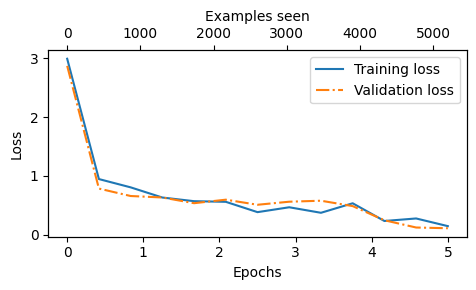

In [138]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

torch.Size([13]) 13


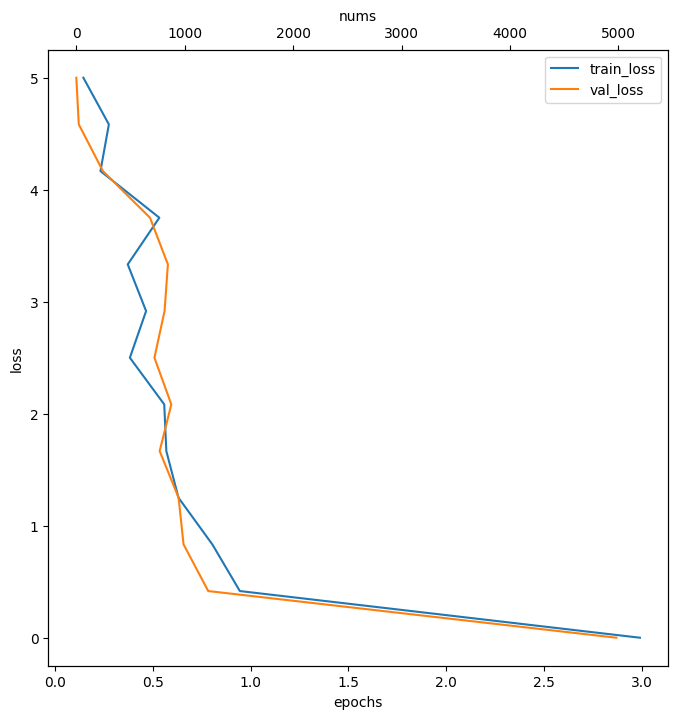

In [146]:
# train_losses, val_losses, train_accs, val_accs, examples_seen  num_epochs = 5
fig,ax1=plt.subplots(figsize=(8,8))

# 长度为train_losses
epochs_seen=torch.linspace(0,num_epochs,len(train_losses))
print(epochs_seen.shape,len(train_losses))
nums_seen=torch.linspace(0,examples_seen,len(train_losses))
ax1.plot(train_losses,epochs_seen,label='train_loss')
ax1.plot(val_losses,epochs_seen,label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

# 公用y轴
ax2=ax1.twiny()
# 设置透明线，仅展示x轴
ax2.plot(nums_seen,train_losses,alpha=0)
ax2.set_xlabel('nums')

plt.show()



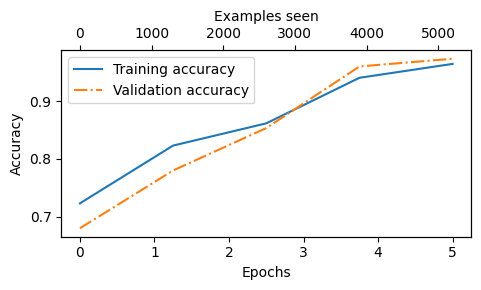

In [140]:

epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")


In [141]:

train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 96.44%
Validation accuracy: 97.33%
Test accuracy: 97.66%


In [152]:
# Listing 6.12 Using the model to classify new texts
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    ids=tokenizer.encode(text)
    # 为什么是1
    support_length=model.pos_emb.weight.shape[1]
    if max_length is not None:
        ids=ids[:min(max_length,support_length)]
    else:
        ids=ids[:support_length]
    # 填充
    # 乘以一个负数，相当于没有操作
    ids=ids+[pad_token_id]*(max_length-len(ids))
    
    # 测试的batch=1
    ids=torch.tensor(ids,device=device).unsqueeze(0)
    with torch.no_grad():
        digits=model(ids)[:,-1,:]
    # 测试的batch=1
    digits=digits.argmax(dim=-1).item()
    
    return 'spam' if digits==1 else 'not spam'

In [153]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [154]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [155]:
# 保存或加载模型
torch.save(model.state_dict(),'review_classifier.pth')
model.load_state_dict(torch.load('review_classifier.pth'))

<All keys matched successfully>